## Obtain daily predictors (DWT)  following the methodoly explained in Anderson et al. (2019)

Tropical cyclone (TC) generation days were withheld from the WT-classification a priori and instead classified within 6 different DWTs depending on the ultimate strength of the TC (notebook 07). 
All remaining days are classified here into 36 extra-tropical DWTs.

inputs required:
  * Waves time series (GOW1: hs, tm dir...)
  * Waves partitions time series (para que???)
  * coastline
  * ESTELA for the site
  * SLP

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, mask_from_poly, Predictor
from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT




## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# load data and set parameters

ls_sea_poly = db.Load_ESTELA_coast()         # ESTELA coastline (land mask)
xds_est = db.Load_ESTELA_data()              # ESTELA D data
xds_WAVES = db.Load_ESTELA_waves()           # ESTELA gow waves point
print(xds_WAVES)
xds_SLP_site = db.Load_ESTELA_SLP()          # ESTELA Sea Level Pressure
xds_wvs_pts = db.Load_WAVES_partitions()     # waves partitions data

_, xds_TCs_r1_params = db.Load_TCs_r1()      # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2011-01-22'
num_clusters = 36
kmarg_alpha = 0.36

# waves point coordinates
pnt_lon = 144.5
pnt_lat = 13.5


<xarray.Dataset>
Dimensions:  (time: 111040)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    hs       (time) float64 2.079 2.134 2.085 2.081 ... 2.159 2.091 2.032 1.932
    phs0     (time) float64 0.1441 0.19 0.168 0.1509 ... 0.1403 0.1241 0.1128
    phs1     (time) float64 1.716 1.368 1.278 1.313 ... 1.529 1.422 1.424 1.418
    phs2     (time) float64 1.139 1.182 1.2 1.244 1.165 ... 1.4 1.4 1.315 1.284
    phs3     (time) float64 0.2206 1.088 1.09 0.9852 ... 0.5605 0.5425 0.2379
    phs4     (time) float64 0.05664 0.2488 0.2187 0.22 ... 0.2324 0.228 0.05955
    phs5     (time) float64 0.05393 0.05729 0.06455 0.08161 ... nan 0.06576 nan
    tp       (time) float64 9.356 9.379 9.433 9.499 ... 9.645 9.404 9.335 9.435
    ptp0     (time) float64 3.213 2.962 4.8 4.335 ... 5.162 3.671 3.346 3.512
    ptp1     (time) float64 8.925 8.998 8.823 5.283 ... 6.021 7.148 9.383 9.521
    ptp2     (time) float64 9.989 5.583 5.285 9.333 ... 9.649 


## ESTELA Predictor - Sea Level Pressure and Gradient

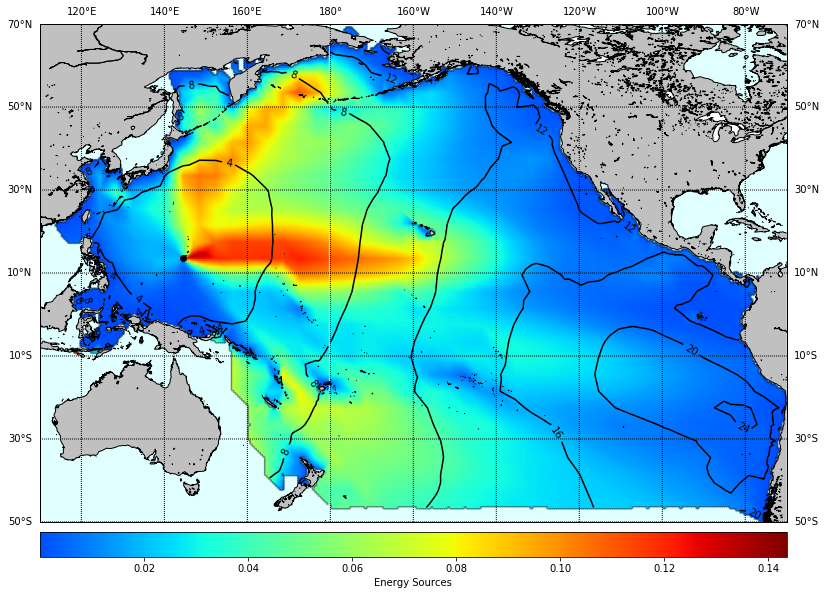

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

Plot_ESTELA(
    pnt_lon, pnt_lat, xds_est.F_y1993to2012, xds_est.D_y1993to2012,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
)

In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
hs = xds_WAVES.hs
#tm = xds_WAVES.t02
tm = xds_WAVES.tp
Fe = np.multiply(hs**2,tm)**(1.0/3)
xds_WAVES.update({
    'Fe':(('time',), Fe)
})

# select time window and calculate daily mean
xds_WAVES = xds_WAVES.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

print(xds_WAVES)


<xarray.Dataset>
Dimensions:  (time: 11689)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
Data variables:
    hs       (time) float64 1.923 1.975 2.145 2.408 ... 1.867 1.871 1.804 1.698
    phs0     (time) float64 nan 0.1742 0.1708 0.1749 ... 0.313 0.1026 0.274
    phs1     (time) float64 1.327 1.482 1.748 2.027 ... 1.769 1.525 1.3 1.229
    phs2     (time) float64 1.063 0.9226 0.9559 1.041 ... 0.8311 0.8553 1.06
    phs3     (time) float64 0.6879 0.7223 0.6147 0.5085 ... 0.3006 0.7369 0.2681
    phs4     (time) float64 0.418 0.4429 0.2697 0.2172 ... 0.2114 0.3615 0.1931
    phs5     (time) float64 0.2027 0.227 0.1382 ... 0.06592 0.1821 0.07615
    tp       (time) float64 10.4 9.647 7.346 8.257 ... 10.21 10.56 15.13 11.74
    ptp0     (time) float64 nan 3.91 4.304 3.491 ... 3.255 11.24 5.019 4.141
    ptp1     (time) float64 7.33 6.552 6.84 7.993 ... 10.22 10.58 7.992 10.33
    ptp2     (time) float64 10.53 9.631 8.685 8.741 ... 10.08 10.58 9.893 

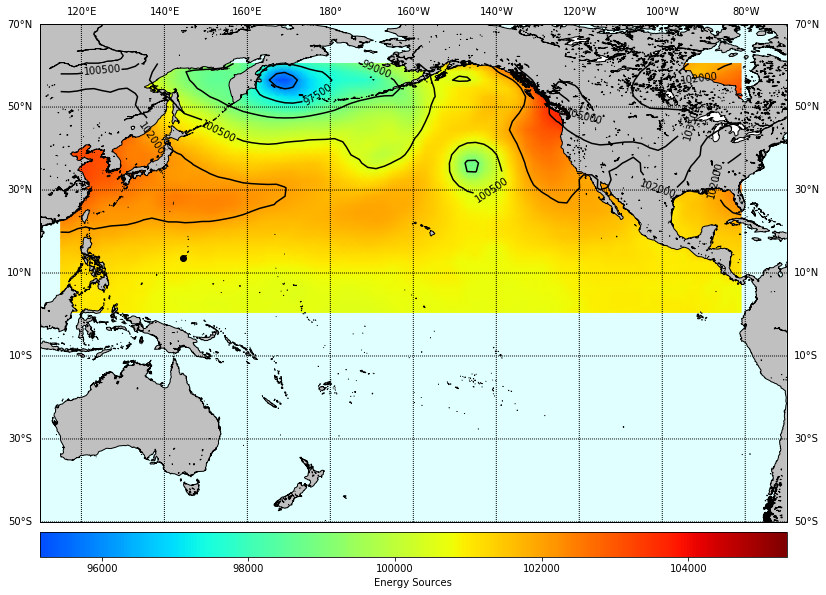

In [6]:
# Plot area of SLP (t=1)

Plot_ESTELA(
    pnt_lon, pnt_lat, xds_SLP_site.SLP.isel(time=1), xds_SLP_site.SLP.isel(time=1),
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
)

In [7]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
xds_SLP_day = xds_SLP_site.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

# calculate daily gradients
xds_SLP_day = spatial_gradient(xds_SLP_day, 'SLP')

# use coastline polygons to generate a land mask
xds_SLP_day = mask_from_poly(xds_SLP_day, ls_sea_poly, 'mask_land')
    
print(xds_SLP_day)
    

<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float64 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float64 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_land     (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0


In [8]:
# --------------------------------------
# Select site ESTELA and generate ESTELA land mask

# select ESTELA at site grid
xds_est_site = xds_est.sel(
    longitude = xds_SLP_site.longitude,
    latitude = xds_SLP_site.latitude,
)
estela_D = xds_est_site.D_y1993to2012

# use ESTELA to generate ESTELA mask
mask_est = np.zeros(estela_D.shape)
mask_est[np.where(estela_D<1000000000)]=1

xds_SLP_day.update({'mask_estela':(('latitude','longitude'), mask_est)})

print(xds_SLP_day)


<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float64 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float64 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_land     (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    mask_estela   (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0



## ESTELA Predictor - Principal Component Analysis

In [9]:
# --------------------------------------
# Calculate ESTELA PCA

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = xds_SLP_day

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 3578, n_features: 3578, n_lat: 31, n_lon: 83, n_points: 5146, time: 11670)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 8.972 18.67 ... 1.188e-15
    EOFs           (n_components, n_features) float64 0.0348 0.03496 ... 0.0 1.0
    variance       (n_components) float64 414.2 217.1 ... 2.315e-30 2.315e-30
    pred_mean      (n_features) float64 1.012e+05 1.013e+05 ... 0.0 0.0
    pred_std       (n_features) float64 553.4 619.2 536.6 429.2 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-10 1979-02-11 ... 2011-01-22
    pred_data_pos  (n_points) bool False False False False ... True True True
Attributes:
    method:     gradient + estela
    pred_name:  SLP


<xarray.Dataset>
Dimensions:        (n_components: 3578, n_features: 3578, n_lat: 31, n_lon: 83, n_points: 5146, time: 11670)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 8.972 18.67 ... 1.188e-15
    EOFs           (n_components, n_features) float64 0.0348 0.03496 ... 0.0 1.0
    variance       (n_components) float64 414.2 217.1 ... 2.315e-30 2.315e-30
    pred_mean      (n_features) float64 1.012e+05 1.013e+05 ... 0.0 0.0
    pred_std       (n_features) float64 553.4 619.2 536.6 429.2 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-10 1979-02-11 ... 2011-01-22
    pred_data_pos  (n_points) bool False False False False ... True True True
Attributes:
    method:     gradient + estela
    pred_name:  SLP


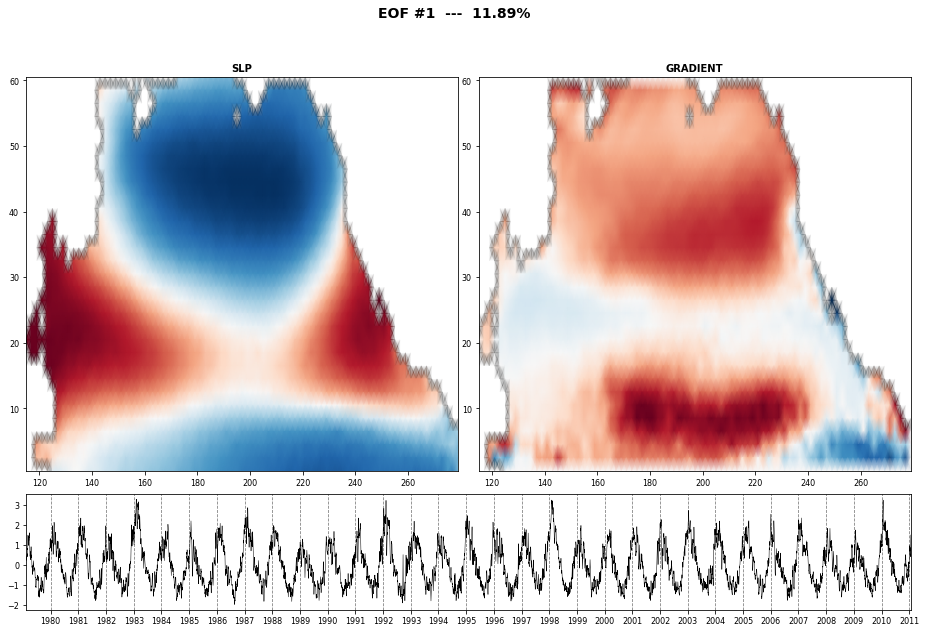

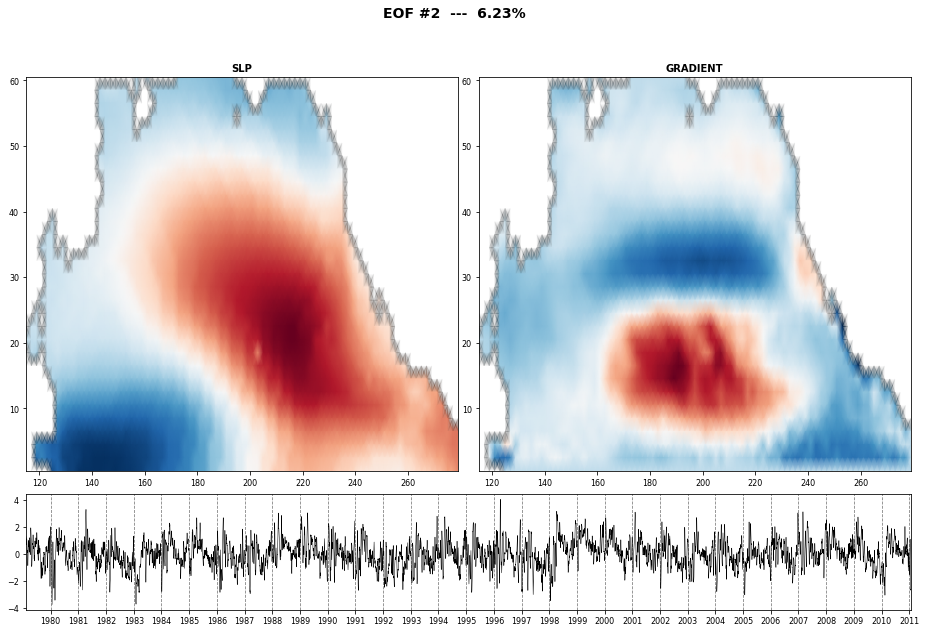

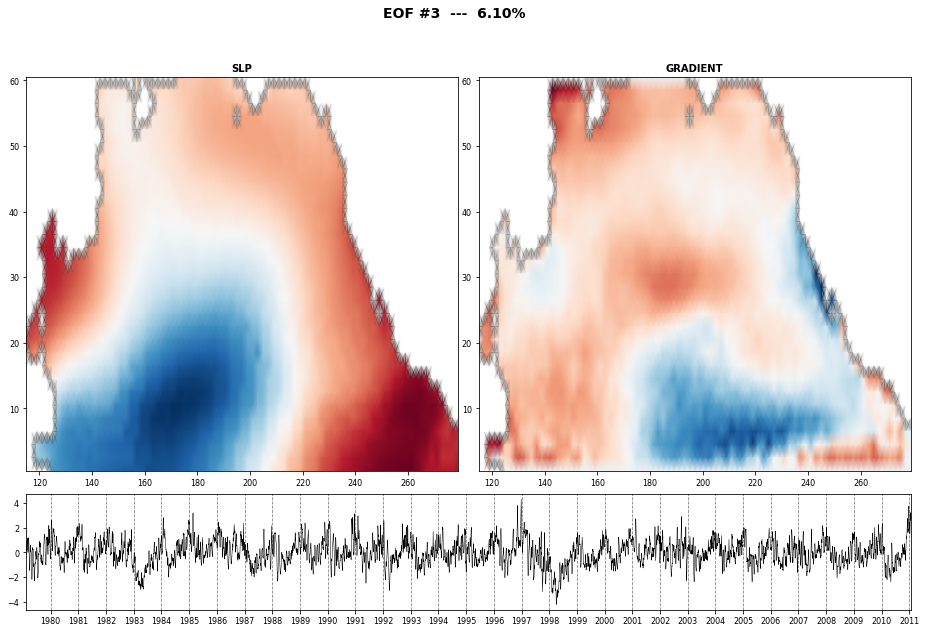

In [10]:
print(pred.PCA)
# plot PCA EOFs
n_EOFs = 3
pred.Plot_EOFs_EstelaPred(n_EOFs, show=True)



## ESTELA Predictor - KMeans Classification

In [11]:
# Calculate KMA (regression guided with WAVES data)

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    xds_WAVES, ['hs','t02','Fe'],
    kmarg_alpha, min_group_size=100)

print(pred.KMA)


KeyError: 't02'

In [ ]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', show=True, mask='mask_estela')


In [ ]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs()


In [ ]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D()


In [ ]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6)


## ESTELA Predictor - Add Historical TCs

In [ ]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = xds_TCs_r1_params.dmin_date.values[:]
storm_categs = xds_TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)


In [ ]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_xds_MUTAU = pred.Calc_MU_TAU_Hydrographs(xds_wvs_pts)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_xds_MUTAU)

# TODO: plot report hydrographs

In [ ]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
xds_MJO_hist, xds_DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = xds_MJO_hist.phase.values[:]
DWT_bmus = xds_DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='MJO Phases / DWT bmus (Historical)')